# Decision Trees for Classification

Implementing decision trees for classification on the spam dataset to determine whether or not an email is spam. 

In [42]:
from collections import Counter

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

import scipy.io
from scipy import stats
from sklearn.model_selection import train_test_split

import sys

import random
random.seed(246810)
np.random.seed(246810)

## Setup: Data Preprocessing



In [43]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) *
                 (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features

def evaluate(dtree, X, y, folds=5):
    print("Cross Validation:")
    train_accuracies = []
    val_accuracies = []
    for i in range(folds):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)
        train_preds = dtree.predict(X_train)
        assert(train_preds.shape == y_train.shape)
        train_accuracy = np.sum(train_preds == y_train) / y_train.shape[0]
        train_accuracies.append(train_accuracy)
        
        val_preds = dtree.predict(X_val)
        assert(val_preds.shape == y_val.shape)
        val_accuracy = np.sum(val_preds == y_val) / y_val.shape[0]
        val_accuracies.append(val_accuracy)
    
    avg_train_accuracy = np.mean(train_accuracies)
    avg_val_accuracy = np.mean(val_accuracies)
    
    print('averaged train accuracy:', avg_train_accuracy)
    print('averaged validation accuracy:', avg_val_accuracy)
    return avg_train_accuracy, avg_val_accuracy

In [44]:
eps = 1e-5  # a small number

dataset = "spam"
N = 100

if dataset == "spam":
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
    ]
    assert len(features) == 32

    # Load spam data
    path_train = './datasets/spam_data/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    Z = data['test_data']
    class_names = ["Ham", "Spam"]

else:
    raise NotImplementedError("Dataset %s not handled" % dataset)

print("Features", features)
print("Train/test size", X.shape, Z.shape)

Features ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size (5172, 32) (5857, 32)


## 1) Decision Tree Implementation



In [45]:
eps = 1e-5  # a small number

class DecisionTree:

    def __init__(self, max_depth=3, features=None, min_samples_split=2):
        '''
        This decision tree data structure is a binary tree that is written recursively. In other words, it has a
        left and right branch that themselves are decision trees with the same attributes and methods.
        
        Attributes:
            - self.max_depth (int): Maximum depth of the tree
            - self.features (List of strings): features that are used to make splits in the decision tree (Basically only used in the __repr__ function)
            - self.left (DecisionTree): Left subtree of this decision tree
            - self.right (DecisionTree): Right subtree of this decision tree
            - self.split_feature (int): The index that corresponds to the feature in self.features that was used to 
                                    split this Decision Tree into its left and right branches
            - self.thresh (int): If the value of the split feature is less than self.thresh, the data point will
                                go to the left subtree. Otherwise, it will go to the right subtree
            - self.leaf_samples (int): The number of samples that are classified at a leaf node
            - self.pred (int): The prediction made at a leaf node. Only assigned at a leaf node.
            - self.min_samples_split (int): The 
        '''
        self.max_depth = max_depth
        self.features = features
        self.left, self.right = None, None  # Attributes only for non-leaf nodes
        self.split_feature, self.thresh = None, None  # Attributes only for non-leaf nodes
        self.leaf_samples, self.pred = None, None  # Attributes only for leaf nodes
        self.min_samples_split = min_samples_split

    @staticmethod
    def entropy(y):
        '''
        Calculate the entropy of the tree at the current node. Remember to take care of the special case where we
        must handle log(0), in which case the entropy should be 0!
        
        Inputs:
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            
        Outputs:
            - Entropy: scalar value between 0 and 1
        
        '''
        
        y_count = np.bincount(y)
        y_prob = y_count/len(y)
        if y_prob.all() == 0:
            return 0
        
        y_prob = y_prob[y_prob != 0]
        
        return -sum(y_prob * np.log(y_prob))
        


    @staticmethod
    def information_gain(X_feat, y, thresh):
        '''
        Calculate the information gain from splitting the data based on a specific feature at a specific threshold
        
        Inputs:
            - X_feat: n x 1 vector representing a column of the X data matrix (a single feature)
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            - thresh: The threshold scalar value to split the feature on
        
        Outputs:
            - Information Gain: Scalar value between 0 and 1
        '''


        split_dat1 = y[np.where(X_feat < thresh)]
        split_dat2 = y[np.where(X_feat >= thresh)]
        
        dt_ent = DecisionTree.entropy(y)
        dt_entsplit1 = DecisionTree.entropy(split_dat1)
        dt_entsplit2 = DecisionTree.entropy(split_dat2)
        
        info_gain = dt_ent - ((dt_entsplit1*len(split_dat1) + dt_entsplit2*len(split_dat2)) / len(y))
        
        return info_gain
        

    
    def feature_split(self, X, y, feature, thresh):
        '''
        Split the data into two halves based on a specific feature at a specific threshold
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            - feature: An index in the range [0, d-1] that represents a specific feature in the data matrix
            - thresh: The threshold scalar value to split the feature on
            
        Outputs:
            - X0: k x d matrix representing the k data points that are split into the left subtree
            - y0: k x 1 vector representing the k class labels that are split into the left subtree
            - X1: (n - k) x d matrix representing the n - k data points that are split into the right subtree
            - y1: (n - k) x 1 vector representing the n - k class labels that are split into the right subtree
        '''
        
        
        X0 = X[np.where(X[:,feature] < thresh)]
        y0 = y[np.where(X[:,feature] < thresh)]
        X1 = X[np.where(X[:,feature] >= thresh)]
        y1 = y[np.where(X[:,feature] >= thresh)]
        
        return X0, y0, X1, y1

    
    def find_feature_thresh(self, X, y, feature):
        '''
        Given the data and the feature, find the best threshold for the feature split. Choose the threshold
        from 10 evenly spaced values between the (min_value + eps) and (max_value - eps) for the feature.
        We need to include the +/- eps for min and max values because without it, there is a chance that the
        training algorithm will split the data on the min or max value, which is not a useful split
        
        Hint: You may find np.linspace helpful
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            - feature: An index in the range [0, d-1] that represents a specific feature in the data matrix
            
        Outputs:
            - max_ig: The largest information gain that is attained
            - best_thresh: The best threshold value that gives us max_ig
        '''
        
        
        threshh = np.linspace(min(X[:, feature]) + eps, max(X[:, feature]) - eps)
        
        max_ig = -sys.maxsize
        best_thresh = -sys.maxsize
        
        for t in threshh:
            val_check = self.information_gain(X[:, feature], y, t)
            if val_check > max_ig:
                best_thresh = t
            max_ig = max(val_check, max_ig)
                
        return max_ig, best_thresh

    
    def find_best_feature_split(self, X, y):
        '''
        Find the best feature and threshold to split on
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            
        Outputs:
            - best_feature: An index in the range [0, d-1] that represents the best feature in the data matrix to split on
            - best_thresh: The best threshold value for best_feature
        '''
        
        best_feature = -sys.maxsize
        best_thresh = -sys.maxsize
        best_featureind = 0
        
        for i in range(X.shape[1] - 1):
            info_gain, threshh = self.find_feature_thresh(X, y, i)
            if best_feature < info_gain:
                best_feature = info_gain
                best_featureind = i
                best_thresh = threshh
        
        return best_featureind, best_thresh


    def fit(self, X, y):
        '''
        Fit the decision tree
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            
        Outputs:
            - None
        '''
        
        if self.max_depth > 0:
            
            self.split_feature, self.thresh = self.find_best_feature_split(X, y)
            X0, y0, X1, y1 = self.feature_split(X, y, self.split_feature, self.thresh)

            if len(X0) >= self.min_samples_split and len(X1) >= self.min_samples_split:

                self.left = DecisionTree(self.max_depth - 1, self.features, self.min_samples_split)
                self.left.fit(X0, y0)

                self.right = DecisionTree(self.max_depth - 1, self.features, self.min_samples_split)
                self.right.fit(X1, y1)

            else:

                self.max_depth = 0
                self.leaf_samples = X
                self.pred = stats.mode(y).mode[0]
                
        else:
            
            self.leaf_samples = X
            self.pred = stats.mode(y).mode[0]

    
    def predict_split(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1
    
    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.predict_split(
                X, idx=self.split_feature, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "[Leaf: %s (%s)]" % (self.pred, self.leaf_samples)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_feature],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())

### Testing Decision Tree



In [46]:
print('==================================================')
print("Entropy Test Cases")

test1 = np.array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

test2 = np.array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1])

test3 = np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

test4 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

''' The first values in the assertions correspond to entropy computed using natural log. 
    The second values correspond to entropy computed using log base 2'''

assert(DecisionTree.entropy(test1) == 0.6913460990017393 or DecisionTree.entropy(test1) == 0.9974015885677396)
print("Test 1 Passed")
assert(DecisionTree.entropy(test2) == 0.6859298002523728 or DecisionTree.entropy(test2) == 0.9895875212220556)
print("Test 2 Passed")
assert(DecisionTree.entropy(test3) == 0.6881388137135884 or DecisionTree.entropy(test3) == 0.9927744539878083)
print("Test 3 Passed")
assert(DecisionTree.entropy(test4) == 0)
print("Test 4 Passed")
assert(DecisionTree.entropy(test4 + 1) == 0)
print("Test 5 Passed")
print("All Test Cases Passed")

Entropy Test Cases
Test 1 Passed
Test 2 Passed
Test 3 Passed
Test 4 Passed
Test 5 Passed
All Test Cases Passed


In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [48]:
# Basic decision tree
print('==================================================')
print("\n\nYour decision tree")
dt = DecisionTree(max_depth=3, features=features)
print(X_train)
print(y_train)
dt.fit(X_train, y_train)
print("Predictions", dt.predict(Z)[:100])
print("Tree structure", dt.__repr__())



Your decision tree
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0 0 0 ... 0 1 1]
Predictions [0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
Tree structure [exclamation < 1e-05: [meter < 1e-05: [parenthesis < 1e-05: [Leaf: 0 ([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]])] | [Leaf: 0 ([[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]])]] | [Leaf: 0 ([[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 3. 0. 0.]
 [0. 0. 0. 

In [49]:
print('==================================================')
print("\n\nCross Validation on your decision tree")
print()
evaluate(dt, X, y)

def evaluate(dtree, X, y, folds=5, display=True):
    if display:
        print("Cross Validation:")
    train_accuracies = []
    val_accuracies = []
    for i in range(folds):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)
        dtree.fit(X_train, y_train) 	### Inserted this line here
        train_preds = dtree.predict(X_train)
        assert(train_preds.shape == y_train.shape)
        train_accuracy = np.sum(train_preds == y_train) / y_train.shape[0]
        train_accuracies.append(train_accuracy)
        
        val_preds = dtree.predict(X_val)
        assert(val_preds.shape == y_val.shape)
        val_accuracy = np.sum(val_preds == y_val) / y_val.shape[0]
        val_accuracies.append(val_accuracy)
    
    avg_train_accuracy = np.mean(train_accuracies)
    avg_val_accuracy = np.mean(val_accuracies)
    
    print('averaged train accuracy:', avg_train_accuracy)
    print('averaged validation accuracy:', avg_val_accuracy)
    return avg_train_accuracy, avg_val_accuracy



Cross Validation on your decision tree

Cross Validation:
averaged train accuracy: 0.7810974135847233
averaged validation accuracy: 0.7735265700483092


## 2) Tree Depth vs. Performance



In [50]:
train_accuracy_depth = []
validation_accuracy_depth = []
for depth in range(1, 40):
    print(depth)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    dt = DecisionTree(max_depth=depth, features=features)
    dt.fit(X_train, y_train)
    
    accuracy = evaluate(dt, X, y)
    
    train_accuracy_depth.append(accuracy[0])
    validation_accuracy_depth.append(accuracy[1])
    


1
Cross Validation:
averaged train accuracy: 0.7642252840222383
averaged validation accuracy: 0.758840579710145
2
Cross Validation:
averaged train accuracy: 0.7810974135847233
averaged validation accuracy: 0.7735265700483092
3
Cross Validation:
averaged train accuracy: 0.7810974135847233
averaged validation accuracy: 0.7735265700483092
4
Cross Validation:
averaged train accuracy: 0.7909112883732173
averaged validation accuracy: 0.7851207729468598
5
Cross Validation:
averaged train accuracy: 0.7987430505197003
averaged validation accuracy: 0.7920772946859903
6
Cross Validation:
averaged train accuracy: 0.8064297800338409
averaged validation accuracy: 0.801159420289855
7
Cross Validation:
averaged train accuracy: 0.8165820642978003
averaged validation accuracy: 0.8123671497584543
8
Cross Validation:
averaged train accuracy: 0.8211264201111916
averaged validation accuracy: 0.8166183574879227
9
Cross Validation:
averaged train accuracy: 0.8231568769639835
averaged validation accuracy: 0.81

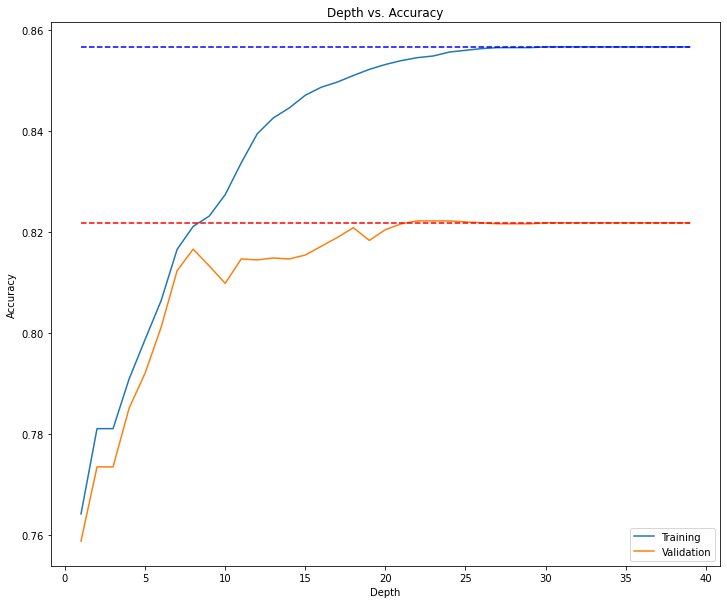

In [51]:
x1 = train_accuracy_depth
x2 = validation_accuracy_depth

plt.figure(figsize=(12,10))
plt.plot(range(1,40), x1, label="Training") 
plt.plot(range(1,40), x2, label="Validation")

plt.plot(range(1,40), np.ones(39)*0.8566594, 'b--')
plt.plot(range(1,40), np.ones(39)*0.8218357, 'r--')

plt.title("Depth vs. Accuracy") 
plt.xlabel("Depth") 
plt.ylabel("Accuracy") 
plt.legend()






